<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_OB_week13_2_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **7.5** LSTM

- RNN에서 가중치가 업데이트되는 과정에서 기울기가 1보다 작은 값이 계속 곱해져 기울기 소멸 문제 발생
  - LSTM, GRU => RNN 방식

##### **7.5.1 LSTM 구조**
- 순전파/역전파 과정





**LSTM 순전파**
- 기울기 소멸 문제 해결하기 위해: 망각 게이트, 입력 게이트, 출력 게이트라는 새로운 요소 은닉층의 각 뉴런에 추가

>**망각 게이트**: 과거 정보를 어느 정도 기억할지 결정
- 과거 정보와 현재 데이터를 입력받아 시그모이드를 취한 후 그 값을 과거 정보에 곱함
- 시그모이드의 출력 = 0 -> 과거 정보 버림
- 시그모이드의 출력 = 1 -> 과거 정보 온전히 보존
$$
f_t = \sigma(w_f [h_{t-1}, x_t])
$$

$$
c_t = f_t \cdot c_{t-1}
$$

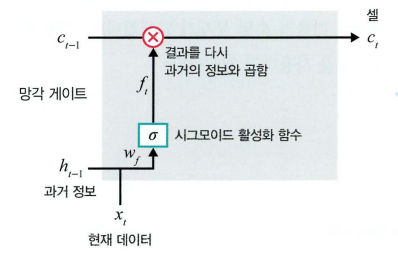






> **입력 게이트**: 현재 정보 기억하기 위해
- 과거 정보와 현재 데이터를 입력받아 시그모이드와 하이퍼볼릭 탄젠트 함수를 기반으로 현재 정보에 대한 보존량 결정
- 계산 값 = 1 -> 입력 $x_1$가 들어올 수 있도록 허용
- 계산 값 = 0 -> 차단
$$
i_t = \sigma(w_i [h_{t-1}, x_t])
$$

$$
\tilde{c}_t = \tanh(w_c [h_{t-1}, x_t])
$$

$$
c_t = c_{t-1} + i_t \cdot \tilde{c}_t
$$

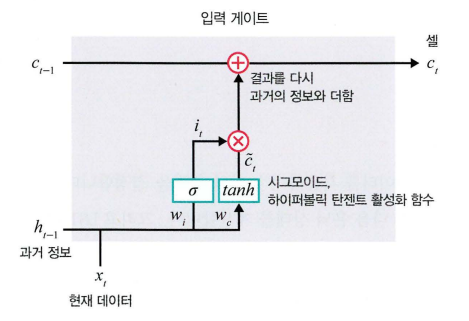



> **셀**: 각 단계에 대한 은닉 노드(hidden node)
- '총합(sum)' 사용하여 셀 값 반영 -> 기울기 소멸 문제 해결
- 망각 게이트, 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태를 업데이트
$$
f_t = \sigma(w_f [h_{t-1}, x_t])
$$

$$
c_t = c_{t-1} + i_t \cdot \tilde{c}_t
$$

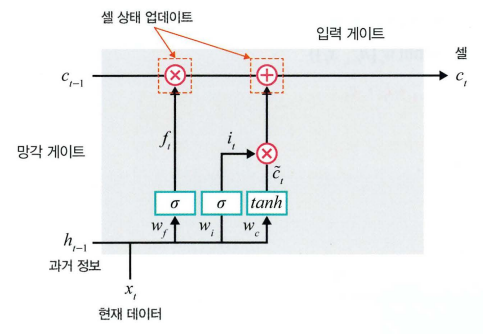




> **출력 게이트**: 과거 정보와 현재 데이터 사용하여 뉴런의 출력 결정
- 이전 은닉 상태와 $t$번째 입력을 고려하여 다음 은닉 상태 계산
- LSTM에서 이 은닉 상태가 그 시점에서의 출력이 됨
- 계산한 값 = 1 -> 의미 있는 결과로 최종 출력
- 계산한 값 = 0 -> 해당 연산 출력 X
$$
o_t = \sigma(w_o [h_{t-1}, x_t])
$$

$$
h_t = o_t \cdot \tanh(c_{t-1})
$$

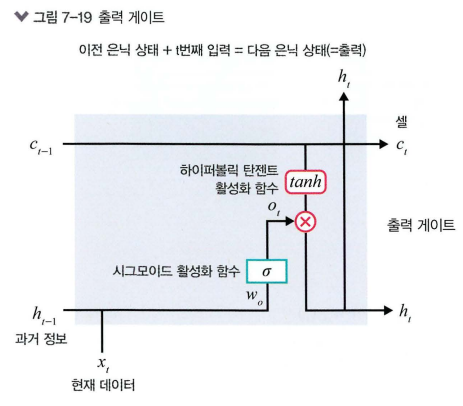

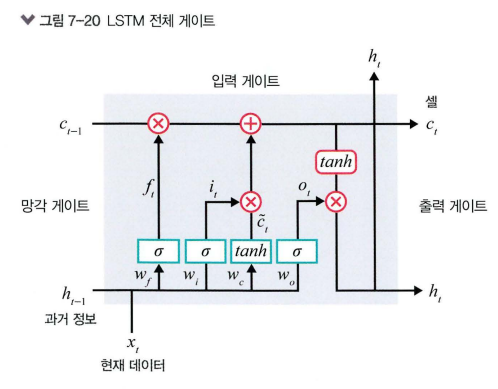



> **LSTM 역전파**: 셀을 통해 역전파를 수행 - '중단 없는 기울기(uninterrupted gradient flow)'
- 최종 오차는 모든 노드에 전파, 셀을 통해 중단 없이 전파
- 셀 단위로 오차가 전파된다고 해서 입력 방향으로 오차가 전파 X
- 셀 내부적으로는 오차가 입력($x_t$)으로 전파됨
$$
t_t = \tanh(w_{hh} h_{t-1} + w_{xh} x_t)
$$

$$
= \tanh \left(
\begin{pmatrix}
w_{hh} & w_{xh}
\end{pmatrix}
\begin{pmatrix}
h_{t-1} \\
x_t
\end{pmatrix}
\right)
$$

$$
= \tanh \left(
W
\begin{pmatrix}
h_{t-1} \\
x_t
\end{pmatrix}
\right)
$$

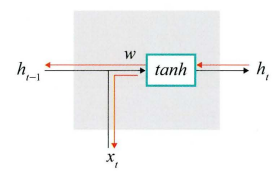


##### **7.5.3 LSTM 셀 구현**
- MNIST 데이터 사용

In [1]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter   # 파라미터 목록을 갖고 있는 라이브러리
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math   # 수학과 관련되어 다양한 함수들과 상수들이 정의되어 있는 라이브러리

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False   # GPU 사용에 필요

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor   # GPU 사용에 필요

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [2]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))   # 평균을 0.5, 표준편차를 1.0으로 데이터 정규화
])                                         # (데이터 분포를 조정)

In [3]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST

download_root = '../chap07/MNIST_DATASET'   # MNIST를 내려받을 경로

train_dataset = MNIST(download_root, transform = mnist_transform, train = True,
                      download = True)   # 1
valid_dataset = MNIST(download_root, transform = mnist_transform, train = False,
                      download = True)
test_dataset = MNIST(download_root, transform = mnist_transform, train = False,
                     download = True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.02MB/s]


1. MNIST 데이터셋 내려받기 위해 필요한 파라미터
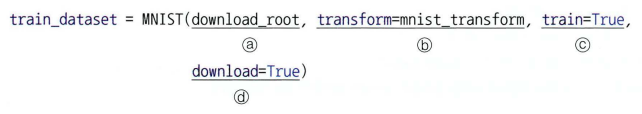

- (a) 첫 번째 파라미터: MNIST 내려받을 위치 지정
- (b) transform: 앞에서 정의했던 데이터 전처리 적용
- (c) train: True로 설정할 경우 -> 훈련용 데이터셋 / False -> 테스트용 데이터셋
- (d) download: True로 설정될 경우 내려받으려는 위치에 MNIST 파일이 없ㅇ면 내려받지만, 있다면 내려받지 않음


In [4]:
# 데이터셋을 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset,
                          batch_size = batch_size,
                          shuffle = True)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = batch_size,
                         shuffle = True)

In [5]:
# 변수 값 지정
batch_size = 100
n_iters = 6000
num_epochs = n_iters/(len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [6]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)   # 1
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)  # 1'
        self.reset_parameters()

    def reset_parameters(self):   # 모델의 파라미터 초기화
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)   # 2

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)   # 1''
        gates = gates.squeeze()              # 3
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)   # 1'''

        ingate = F.sigmoid(ingate)           # 입력 게이트에 시그모이드 활성화 함수 적용
        forgetgate = F.sigmoid(forgetgate)   # 망각 게이트에 시그모이드 활성화 함수 적용
        cellgate = F.tanh(cellgate)          # 셀 게이트에 탄젠트 활성화 함수 적용
        outgate = F.sigmoid(outgate)         # 출력 게이트에서 시그모이드 활성화 함수 적용

        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)   # 4
        hy = torch.mul(outgate, F.tanh(cy))                             # 4'
        return (hy, cy)

1.1' 왜 은닉층의 뉴런/유닛에 4를 곱할까?
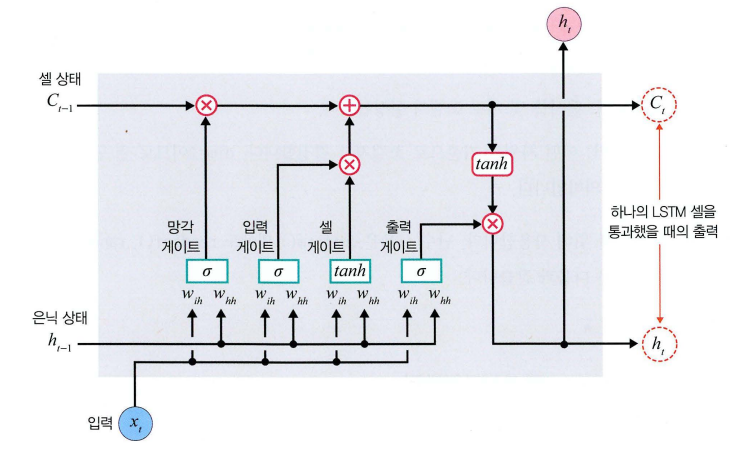

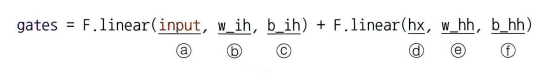
- (a) 입력층으로 입력되는 훈련 데이터셋의 특성 수 (칼럼 개수)
- (b) 입력층과 은닉층 사이의 가중치
- (c) 입력층과 은닉층 사이의 바이어스
- (d) 은닉층의 뉴런/유닛 개수(은닉층의 특성 수)
- (e) 은닉층과 은닉층 사이의 가중치
- (f) 은닉층과 은닉층 사이의 바이어스

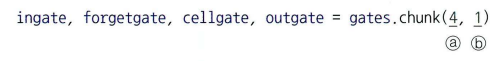
- (a) 첫 번째 파라미터: 텐서를 몇 개로 쪼갤지 설정
- (b) 두 번째 파라미터: 어떤 차원을 기준으로 쪼갤지 결정

2. uniform(): 난수를 위해 사용
  - uniform(), radient(), random()

```
from random import *

ri = randint(1, 10)      # 1부터 10사이의 임의의 정수
print(ri)

rd = random()            # 0부터 1사이의 임의의 실수(float)
print(rd)

ui = uniform(1, 10)      # 1부터 10사이의 임의의 실수(float)
print(ui)

rr = randrange(1, 10, 2) # 1부터 10 사이를 2씩 건너뛴 임의의 정수
print(rr)
```

3. torch.squeeze(): 텐서의 차원을 줄이고자 할 때 사용


```
import torch
x = torch.FloatTensor([[1], [2]])   # (2x1)크기의 2차원 텐서 생성
print(x)
print(x.shape)
print('--squeeze 적용--')
print(x.squeeze( ))                 # squeeze()가 적용되어 1 차원으로 축소
print(x.squeeze().shape)
```

4. 4': 하나의 LSTM 셀을 통과하면 셀($c_1$)상태와 은닉 상태($h_1$)가 출력으로 주어짐
  - 셀 상태는 입력, 망각, 셀 게이트에 의해 계산
  - 은닉 상태는 출력 게이트에 의해 계산


```
import torch
x = torch.FloatTensor([[1], [2]])   # 임의의 텐서 생성
print(x)
print('--mul 적용--')
torch.mul(x, 3)                     # x라는 텐서의 원소에 3을 곱함
```



In [8]:
# 2
print("\n" + "="*30 + "\n# 2\n")

from random import *

ri = randint(1, 10)                 # 1부터 10사이의 임의의 정수
print(ri)

rd = random()                       # 0부터 1사이의 임의의 실수(float)
print(rd)

ui = uniform(1, 10)                 # 1부터 10사이의 임의의 실수(float)
print(ui)

rr = randrange(1, 10, 2)            # 1부터 10 사이를 2씩 건너뛴 임의의 정수
print(rr)

# 3
print("\n" + "="*30 + "\n# 3\n")

import torch
x = torch.FloatTensor([[1], [2]])   # (2x1)크기의 2차원 텐서 생성
print(x)
print(x.shape)
print('--squeeze 적용--')
print(x.squeeze( ))                 # squeeze()가 적용되어 1 차원으로 축소
print(x.squeeze().shape)

# 4,4'
print("\n" + "="*30 + "\n# 4 & 4'\n")

import torch
x = torch.FloatTensor([[1], [2]])   # 임의의 텐서 생성
print(x)
print('--mul 적용--')
torch.mul(x, 3)                     # x라는 텐서의 원소에 3을 곱함


# 2

3
0.3461652596129081
2.9619859945591798
1

# 3

tensor([[1.],
        [2.]])
torch.Size([2, 1])
--squeeze 적용--
tensor([1., 2.])
torch.Size([2])

# 4 & 4'

tensor([[1.],
        [2.]])
--mul 적용--


tensor([[3.],
        [6.]])

In [9]:
# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수

        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)   # 1
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available(): # GPU 사용 유무 확인
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
            # 은닉층의 계층 개수, 배치크기, 은닉층의 뉴런 개수)형태를 갖는 은닉 상태를 0으로 초기화
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available(): # GPU 사용 유무 확인
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
            # 은닉층의 계층 개수, 배치크기, 은닉층의 뉴런 개수)형태를 갖는 셀 상태를 0으로 초기화
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

        outs = []
        cn = c0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
        hn = h0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

        for seq in range(x.size(1)):   # LSTM 셀 계층을 반복하여 쌓아 올립니다
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과를 또다시 hn, cn에 저장
            outs.append(hn)

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

1. LSTM셀은 앞에서 정의한 함수를 불러오는 부분
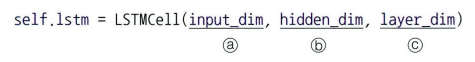
- (a) input_dim: 입력에 대한 특성 수 (칼럼 개수)
- (b) hidden_dim: 은닉층의 뉴런 개수
- (c) layer_dim: 은닉층의 계층 개수

In [10]:
# 옵티마이저와 손실 함수 지정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():   # GPU 사용 유무 확인
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# 모델 학습 및 성능 확인
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # 훈련 데이터셋을 이용한 모델 학습
        if torch.cuda.is_available():                     # GPU 사용 유무 확인
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())   # 1
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)   # 손실 함수를 이용하여 오차 계산

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()   # 파라미터 업데이트
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:   # 정확도(accuracy) 계산
            correct = 0
            total = 0
            for images, labels in valid_loader:   # 검증 데이터셋을 이용한 모델 성능 검증

                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)   # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기

                total += labels.size(0)   # 총 레이블 수
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(),
                                                                 accuracy))

Iteration: 500. Loss: 2.237457513809204. Accuracy: 21.420000076293945
Iteration: 1000. Loss: 1.000300645828247. Accuracy: 68.05000305175781
Iteration: 1500. Loss: 0.437739759683609. Accuracy: 88.5
Iteration: 2000. Loss: 0.2632399797439575. Accuracy: 93.4800033569336
Iteration: 2500. Loss: 0.06545580178499222. Accuracy: 95.81999969482422
Iteration: 3000. Loss: 0.07952357083559036. Accuracy: 95.66999816894531
Iteration: 3500. Loss: 0.09944175183773041. Accuracy: 95.44999694824219
Iteration: 4000. Loss: 0.021778566762804985. Accuracy: 97.08000183105469
Iteration: 4500. Loss: 0.053435660898685455. Accuracy: 97.04000091552734
Iteration: 5000. Loss: 0.10422689467668533. Accuracy: 97.43000030517578
Iteration: 5500. Loss: 0.11725344508886337. Accuracy: 96.95999908447266
Iteration: 6000. Loss: 0.028016990050673485. Accuracy: 97.76000213623047
Iteration: 6500. Loss: 0.014547629281878471. Accuracy: 97.66999816894531
Iteration: 7000. Loss: 0.023513026535511017. Accuracy: 97.9000015258789
Iteration

1. 현재 버전에서는 모든 텐서가 자동으로 Variable 성질을 가져 사용할 필요가 없지만 학습/연습, 이전 버전에서 구현된 파이토치 코드 이해하기 위해 사용

In [12]:
# 테스트 데이터셋으르 이용한 모델 예측 성능 확인
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():   # GPU 사용 유무 확인
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction = "sum")   # reduction='sum'을 지정했기 때문에 모든 오차를 더합니다
        _, predicted = torch.max(logit.data, 1)                    # logit.data 텐서에서 최댓값의 인덱스(index)를 반환
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [13]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.06 | Test Accuracy:  0.98


- 사전에 전처리 되지 않은 데이터셋의 경우 정확도를 높이기 위해 은닉층의 개수(/뉴런의 개수) 및 하이퍼파라미터 수정 등이 필요

##### **7.5.3 LSTM 계층 구현**
- 스타벅스 주가 데이터셋 사용
- 모델이 얼마나 주가 예측을 잘 하는지 확인

In [14]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
# 1. 저장소 전체를 clone
!git clone https://github.com/gilbutITbook/080289.git

# 2. 작업 디렉토리를 해당 폴더로 이동
%cd 080289/chap07/data/

# 3. 파일 목록 확인
!ls

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.
/content/080289/chap07/data
sales.csv  SBUX.csv


In [16]:
# 데이터셋 가져오기
data = pd.read_csv('/content/080289/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [17]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)   # 'date' 칼럼을 인덱스로 사용

In [18]:
# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float)   # 데이터 형식을 변경할 때 astype() 사용

In [19]:
# 훈련과 레이블 분리
X=data.iloc[:,:-1]   # 마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y=data.iloc[:,5:6]   # 마지막 'Volume'을 레이블로 사용
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [20]:
# 데이터 분포 조정
ms = MinMaxScaler()         # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler()       # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]     # 훈련 데이터셋
X_test = X_ss[200:, :]      # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [21]:
# 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))   # Variable로 감싸진 텐서는 .backward()가
X_test_tensors = Variable(torch.Tensor(X_test))     # 호출될 때 자동으로 기울기가 계산

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                  1, X_train_tensors.shape[1]))   # 1
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


1. torch.reshape: 텐서의 형태를 바꿀 때 사용
  - 훈련 데이터셋(X_train_tensors)의 형태를 (200, 5) -> (200, 1, 5)

In [22]:
# LSTM 네트워크
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes   # 클래스 개수
        self.num_layers = num_layers     # LSTM 계층의 개수
        self.input_size = input_size     # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size   # 은닉층의 뉴런 개수
        self.seq_length = seq_length     # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)   # LSTM 계층
        self.fc_1 =  nn.Linear(hidden_size, 128)   # 완전연결층
        self.fc = nn.Linear(128, num_classes)      # 출력층
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))   # 셀 상태를 0으로 초기화

        output, (hn, cn) = self.lstm(x, (h_0, c_0))   # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)            # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.relu(hn)                           # (1차원으로 조정)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [23]:
# 변수 값 설정
num_epochs = 1000        # 1000번의 에포크
learning_rate = 0.0001   # 학습률을 0.0001로 지정

input_size = 5           # 입력 데이터셋의 칼럼(feature) 개수
hidden_size = 2          # 은닉층의 뉴런/유닛 개수
num_layers = 1           # LSTM 계층의 개수

num_classes = 1          # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers,
             X_train_tensors_f.shape[1])   # 앞에서 정의한 값들을 이용하여 LSTM 모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [24]:
# 모델 학습
for epoch in range(num_epochs):   # 1000번 반복
    outputs = model.forward(X_train_tensors_f)   # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)   # 손실 함수를 이용한 오차 계산(모델 학습 결과 outputs와)
    loss.backward()   # 기울기 계산              # 레이블(y_train_tensors)의 차이 계산

    optimizer.step()  # 오차 업데이트
    if epoch % 100 == 0:   # 1000을 100으로 나누어 나머지가 0이면 출력
        print('Epoch : %d, loss : %1.5f' % (epoch, loss.item()))

Epoch : 0, loss : 0.18287
Epoch : 100, loss : 0.05713
Epoch : 200, loss : 0.03855
Epoch : 300, loss : 0.03717
Epoch : 400, loss : 0.03599
Epoch : 500, loss : 0.03326
Epoch : 600, loss : 0.02937
Epoch : 700, loss : 0.02517
Epoch : 800, loss : 0.02214
Epoch : 900, loss : 0.02043


- 오차 위주로 출력하여 실제로 얼마나 잘 예측했는지 알기 어려움
- 예측 결과를 시각적으로 표현하기 전 전처리 진행(데이터의 분포 및 형태 변경)

In [25]:
# 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1])   # 데이터 정규화(분포 조정)
df_y_ms = ms.transform(data.iloc[:, -1:])   # 데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

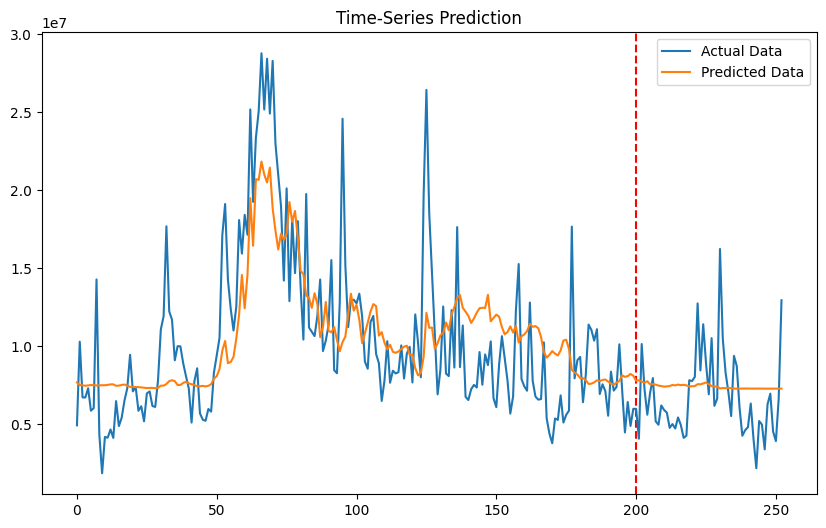

In [26]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)           # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy()   # 모델 학습 결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted)   # 모델 학습을 위해 전처리(정규화)했던 것을 해제
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')    # 1

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

- 파란색: 실제 레이블에 대한 출력 결과
- 주황색: 모델이 예측한 결과 -> 만족스럽지 않은 결과

1. axvline(): 그래프의 축을 따라 수직선을 표현

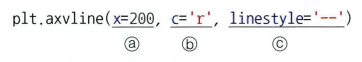
- (a) 첫 번째 파라미터: 어떤 지점에 수직선을 표현할지 지정
- (b) c: 어떤 색상으로 수직선을 표현할지 지정
- (c) linestyle: 어떤 스타일로 수직선을 표현할지 지정